In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn 

import sys
sys.path.append("..")
from dataset_generation.randomDataset import RandomDataset
from classifier.dataset import SoundDataset
from utils.cnn import CNNNetwork
from utils.lstm import LSTMNetwork
from utils import LABELS
from utils.numpyDataset import NumpyDataset
from encodec.utils import convert_audio

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
sr = 8000
num_samples = 12000
nfft=512
nmels=60
f_min=0
f_max=None

batch_size = 128
num_epochs = 150
loss = torch.nn.CrossEntropyLoss()

cuda


In [4]:
directories =  [
 #'audioMnist-pitch-up',
 'audioMinst',
 #'audioMnistPitchShiftedDown',
 #'audioMnistNoise',
 'jenniferMnist'

]

12002
shape of feature: torch.Size([1, 60, 47])
datatype torch.float32


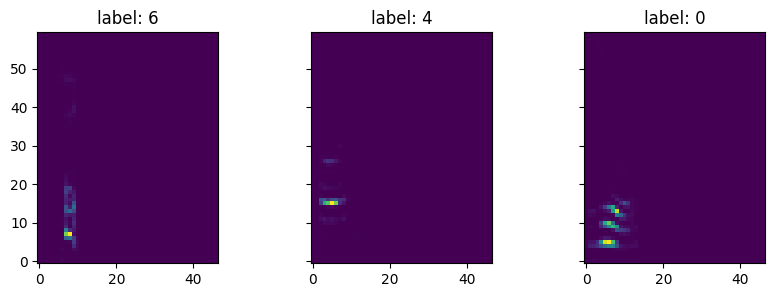

In [5]:

melSpec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=nfft, n_mels=nmels, f_min=f_min, f_max=f_max)
def transform(wav):
    a1 = random.sample(augmentations, 1)[0]
    wav = aug.apply(wav, a1)
    spec = mel
    return melSpec(wav)

dataSet = SoundDataset(directories, transformation=melSpec, target_sample_rate=sr, num_samples=num_samples, device=device)
print(len(dataSet))
train_data, val_data = torch.utils.data.random_split(dataSet, (0.8, 0.2))
train_dl = DataLoader(train_data, batch_size=batch_size)
val_dl = DataLoader(val_data, batch_size=batch_size)

input_shape = None

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
for i in range(3):
    img, label = val_data[i]
    if i==0:
        print('shape of feature:', img.shape)
        print('datatype', img.dtype)
        input_shape = img.shape
    axs[i].imshow(img[0].cpu(), origin='lower')
    axs[i].set_title(f'label: {label}')


In [32]:
model2 = CNNNetwork(out_neurons=10, input_shape=(1, 60, 188), layers=[8, 16, 32, 64], stride=(1, 1))
model2(torch.rand(1, 1, 60, 188))
model2 = model2.to(device)
#model = LSTMNetwork(inp#ut_dim=8, hidden_dim=32, lstm_layers=1, linear_layers=[16, 10])
resnet18 = models.resnet18(pretrained=True)
# Set all parameters in the model to non-trainable (requires_grad=False)
for param in resnet18.parameters():
    param.requires_grad = False
# Pass your Mel spectrogram through the model

# deletes the last layer of resnet and replace it with two of our own linear layers
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])
new_fc =  torch.nn.Linear(512, 256)
new_fc2 = torch.nn.Linear(256, 10)
new_layers = nn.Sequential(
    nn.Flatten(),
    new_fc,
    nn.ReLU(),
    new_fc2,
    nn.Softmax(dim=1)
)

resnet18_modified = nn.Sequential(
    resnet18,
    new_layers
)

model = resnet18_modified.to(device)
print(model)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

852992
torch.Size([1, 1, 60, 188])
torch.Size([1, 8, 31, 95])
torch.Size([1, 16, 16, 48])
torch.Size([1, 32, 9, 25])
torch.Size([1, 64, 5, 13])
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 

In [33]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        input, target = input.to(device), target.to(device)
        input = torch.cat((input, input, input), dim=1)
        #input = torch.cat((input, input, input, input), dim=3)
        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    metrics['t_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['t_loss'].append((sum(losses)/sum(accuracies)).cpu())
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        input = torch.cat((input, input, input), dim=1)
        input, target = input.to(device), target.to(device)

        #nput = torch.cat((input, input, input, input), dim=3)

        prediction = model(input)
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
    
    metrics['v_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['v_loss'].append((sum(losses)/sum(accuracies)).cpu())

          

In [34]:
metrics = {
    't_loss': [],
    'v_loss': [],
    't_acc': [],
    'v_acc': []
}
print('****** STARTING TRAINING ******')
for epoch in range(50):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch} Val loss: {metrics['v_loss'][-1]}, Val acc: {metrics['v_acc'][-1]}")

print("Fininshed training")    
print('best validation accuracy', max(metrics['v_acc']).data)

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

plt.figure(1)
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')

****** STARTING TRAINING ******
Finished epoch: 0 Val loss: 16.936359405517578, Val acc: 0.1352796107530594
Finished epoch: 1 Val loss: 13.357015609741211, Val acc: 0.17023026943206787


KeyboardInterrupt: 

In [ ]:
## SAVE THE MODEL, INCLUDING THE SPECOGRAM PARAMETERS
